In [1]:
from cloudvolume import CloudVolume
from skimage.transform import downscale_local_mean
import napari
from skimage import io
import random
import h5py
from skimage import measure
from brainlit.preprocessing import removeSmallCCs
import numpy as np 
import matplotlib.pyplot as plt 
import subprocess
import tables
%gui qt5

/Users/thomasathey/Documents/mimlab/mouselight/env/lib/python3.8/site-packages/python_jsonschema_objects/__init__.py:50: UserWarning: Schema version http://json-schema.org/draft-04/schema not recognized. Some keywords and features may not be supported.
  warnings.warn(


# Download benchmark data

In [2]:

dir = "precomputed://https://dlab-colm.neurodata.io/2021_04_08/gad2cre_tph2flp_con_fon_8291/561"
mip = 0

vol_bg = CloudVolume(dir, parallel=1, mip=mip, fill_missing=True)
shape = vol_bg.shape
print(shape)

dir = "precomputed://https://dlab-colm.neurodata.io/2021_04_08/gad2cre_tph2flp_con_fon_8291/642"
mip = 0

vol_fg = CloudVolume(dir)
shape = vol_fg.shape
print(shape)

dir = "precomputed://https://dlab-colm.neurodata.io/2021_04_08/gad2cre_tph2flp_con_fon_8291/axon_mask"
dir = "s3://smartspim-precomputed-volumes/2021_04_08/gad2cre_tph2flp_con_fon_8291/axon_mask"
mip = 0

vol_mask = CloudVolume(dir, parallel=1, mip=mip, fill_missing=True)
shape = vol_mask.shape
print(shape)


[ 7403 10240  4800     1]
[ 7403 10240  4800     1]
[ 7403 10240  4800     1]


In [31]:
centers_train = [[2477, 3638, 2409], [3605, 2873, 2405], [4939, 5186, 2398], [4538, 5148, 2398], [4618, 3225, 2388], [3223, 5206, 3550], [1953, 2102, 3577], [2395, 5004, 3584], [941, 3711, 708], [2030, 2164, 701], [3283, 3406, 1255], [1531, 2220, 1242], [2569, 6420, 2924], [2282, 8206, 2924], [4424, 5689, 2896], [3269, 3987, 2896], [2817, 6831, 4565], [3308, 3276, 4124], [4560, 6354, 4133], [4293, 2411, 2297], [5254, 5429, 2877], [3851, 2185, 2877], [2261, 8272, 2877], [3970, 3496, 2877], [1277, 2284, 2877]]
centers_val = [[5701, 3357, 4137], [3610, 2346, 4137], [2564, 4086, 2829], [1282, 2182, 2829], [3960, 2836, 1546], [2347, 4866, 1545], [1680, 4284, 806], [3223, 3294, 2514], [3564, 3847, 2516], [2620, 7237, 4610]]

In [33]:
for i, center in enumerate(centers_train):
    if i < 20:
        continue
    image_fg = vol_fg[center[0]-49:center[0]+50,center[1]-49:center[1]+50, center[2]-49:center[2]+50]
    image_fg = image_fg[:,:,:,0]

    image_bg = vol_bg[center[0]-49:center[0]+50,center[1]-49:center[1]+50, center[2]-49:center[2]+50]
    image_bg = image_bg[:,:,:,0]
    image_2channel = np.stack([image_bg, image_fg], axis=0)
    
    fname = "/Users/thomasathey/Documents/mimlab/mouselight/ailey/benchmark_formal/train_" + str(i) + ".h5"
    with h5py.File(fname, "w") as f:
        dset = f.create_dataset("image_2channel", data=image_2channel)
    

Downloading: 380it [00:03, 110.68it/s]
Downloading: 382it [00:02, 132.71it/s]
Downloading: 782it [00:05, 148.03it/s]
Downloading: 782it [00:05, 144.49it/s]
Downloading: 788it [00:07, 106.23it/s]
Downloading: 786it [00:11, 67.38it/s] 
Downloading: 784it [00:11, 69.80it/s] 
Downloading: 786it [00:11, 70.97it/s] 
Downloading: 786it [00:10, 71.54it/s] 
Downloading: 786it [00:10, 73.63it/s] 


## View data

In [40]:
center = centers_train[23]

image_fg = vol_fg[center[0]-49:center[0]+50,center[1]-49:center[1]+50, center[2]-49:center[2]+50]
image_fg = image_fg[:,:,:,0]

image_bg = vol_bg[center[0]-49:center[0]+50,center[1]-49:center[1]+50, center[2]-49:center[2]+50]
image_bg = image_bg[:,:,:,0]

viewer = napari.Viewer(ndisplay=3)
viewer.add_image(image_fg)
viewer.add_image(image_bg)

Downloading: 780it [00:04, 185.55it/s]
Downloading: 786it [00:04, 173.61it/s]


<Image layer 'image_bg' at 0x16d617130>

## Check training results

In [19]:
true_pos_total = 0
false_pos_total = 0
true_labels_total = 0

for i in range(20):
    fname = "/Users/thomasathey/Documents/mimlab/mouselight/ailey/benchmark_formal/train_" + str(i) + ".h5"
    f = h5py.File(fname, 'r')
    im = f.get('image_2channel')
    im_bg = im[0,:,:,:]
    im_fg = im[1,:,:,:]

    fname = "/Users/thomasathey/Documents/mimlab/mouselight/ailey/benchmark_formal/train_" + str(i) + "-image_2channel_Labels.h5"
    f = h5py.File(fname, 'r')
    gt = f.get('exported_data')
    gt = gt[0,:,:,:]
    pos_labels = gt == 2
    num_pos_labels = np.sum(pos_labels)

    fname = "/Users/thomasathey/Documents/mimlab/mouselight/ailey/benchmark_formal/train_" + str(i) + "-image_2channel_Probabilities.h5"
    f = h5py.File(fname, 'r')
    seg = f.get('exported_data')
    seg = seg[1,:,:,:]
    mask = seg > 0.5

    true_pos = np.sum(np.logical_and(mask, pos_labels))
    true_pos_total += true_pos
    false_pos = np.sum(np.logical_and(mask, gt == 1))
    false_pos_total += false_pos
    true_labels = np.sum(pos_labels)
    true_labels_total += true_labels
    
    if num_pos_labels > 0:
        precision = true_pos/(true_pos + false_pos)
        recall = true_pos/true_labels
        print(f"Example {i}: precision: {precision}, recall: {recall}")
    else:
        print(f"Example {i}: 0 positive labels, false positive rate is: {false_pos/np.sum(gt == 1)}")

    '''
    viewer = napari.Viewer(ndisplay=3)
    viewer.add_image(im_bg)
    viewer.add_image(im_fg)
    viewer.add_labels(gt)
    viewer.add_labels(mask)
    '''
print(f"Total precision: {true_pos_total/(true_pos_total + false_pos_total)} total recall: {true_pos_total/true_labels_total} with {true_labels_total} total positive voxels")

Example 0: precision: 1.0, recall: 1.0
Example 1: 0 positive labels, false positive rate is: 0.0
Example 2: 0 positive labels, false positive rate is: 0.0
Example 3: 0 positive labels, false positive rate is: 0.0
Example 4: 0 positive labels, false positive rate is: 0.0
Example 5: 0 positive labels, false positive rate is: 0.0
Example 6: precision: 1.0, recall: 1.0
Example 7: precision: 1.0, recall: 1.0
Example 8: 0 positive labels, false positive rate is: 0.0
Example 9: 0 positive labels, false positive rate is: 0.0
Example 10: precision: 1.0, recall: 1.0
Example 11: 0 positive labels, false positive rate is: 0.0
Example 12: precision: 1.0, recall: 1.0
Example 13: 0 positive labels, false positive rate is: 0.0
Example 14: 0 positive labels, false positive rate is: 0.0
Example 15: 0 positive labels, false positive rate is: 0.0
Example 16: 0 positive labels, false positive rate is: 0.0
Example 17: 0 positive labels, false positive rate is: 0.0
Example 18: 0 positive labels, false positi

## Check Val results

Thresh: 0.02 --- Total prec.: 0.361 total rec.: 0.980 w/761 total pos voxels. F-score: 0.5281
Thresh: 0.04 --- Total prec.: 0.379 total rec.: 0.966 w/1522 total pos voxels. F-score: 0.5445
Thresh: 0.06 --- Total prec.: 0.396 total rec.: 0.951 w/2283 total pos voxels. F-score: 0.5589
Thresh: 0.08 --- Total prec.: 0.411 total rec.: 0.939 w/3044 total pos voxels. F-score: 0.5715
Thresh: 0.10 --- Total prec.: 0.424 total rec.: 0.929 w/3805 total pos voxels. F-score: 0.5821
Thresh: 0.12 --- Total prec.: 0.435 total rec.: 0.920 w/4566 total pos voxels. F-score: 0.5909
Thresh: 0.14 --- Total prec.: 0.445 total rec.: 0.910 w/5327 total pos voxels. F-score: 0.5976
Thresh: 0.16 --- Total prec.: 0.453 total rec.: 0.900 w/6088 total pos voxels. F-score: 0.6027
Thresh: 0.18 --- Total prec.: 0.461 total rec.: 0.891 w/6849 total pos voxels. F-score: 0.6074
Thresh: 0.20 --- Total prec.: 0.467 total rec.: 0.883 w/7610 total pos voxels. F-score: 0.6109
Thresh: 0.22 --- Total prec.: 0.473 total rec.: 0.8

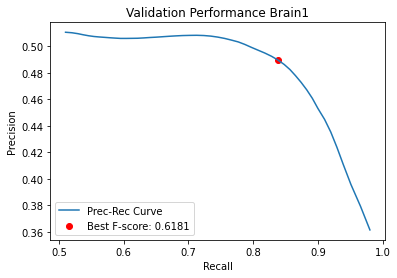

In [19]:
true_pos_total = 0
false_pos_total = 0
true_labels_total = 0
spacing =  0.02
thresholds = np.arange(spacing, 1.0, spacing)
precisions = []
recalls = []
best_fscore = 0

for threshold in thresholds:
    for i in range(10):
        fname = "/Users/thomasathey/Documents/mimlab/mouselight/ailey/benchmark_formal/val_" + str(i) + ".h5"
        f = h5py.File(fname, 'r')
        im = f.get('image_2channel')
        im_bg = im[0,:,:,:]
        im_fg = im[1,:,:,:]

        fname = "/Users/thomasathey/Documents/mimlab/mouselight/ailey/benchmark_formal/val_" + str(i) + "-image_2channel_Labels.h5"
        f = h5py.File(fname, 'r')
        gt = f.get('exported_data')
        gt = gt[0,:,:,:]
        pos_labels = gt == 2
        num_pos_labels = np.sum(pos_labels)

        fname = "/Users/thomasathey/Documents/mimlab/mouselight/ailey/benchmark_formal/val_" + str(i) + "_Probabilities.h5"
        f = h5py.File(fname, 'r')
        seg = f.get('exported_data')
        seg = seg[1,:,:,:]
        mask = seg > threshold

        true_pos = np.sum(np.logical_and(mask, pos_labels))
        true_pos_total += true_pos
        false_pos = np.sum(np.logical_and(mask, gt == 1))
        false_pos_total += false_pos
        true_labels = np.sum(pos_labels)
        true_labels_total += true_labels
        
        if num_pos_labels > 0:
            precision = true_pos/(true_pos + false_pos)
            recall = true_pos/true_labels
            #print(f"Example {i}: precision: {precision}, recall: {recall}")
        else:
            #print(f"Example {i}: 0 positive labels, false positive rate is: {false_pos/np.sum(gt == 1)}")
            pass
        '''
        viewer = napari.Viewer(ndisplay=3)
        viewer.add_image(im_bg)
        viewer.add_image(im_fg)
        viewer.add_labels(gt)
        viewer.add_labels(mask)
        '''
    precision_total = true_pos_total/(true_pos_total + false_pos_total)
    recall_total = true_pos_total/true_labels_total
    fscore = 2/(1/precision_total+1/recall_total)
    print(f"Thresh: {threshold:.2f} --- Total prec.: {precision_total:.3f} total rec.: {recall_total:.3f} w/{true_labels_total} total pos voxels. F-score: {fscore:.4f}")
    if fscore > best_fscore:
        best_fscore = fscore
        best_prec = precision_total
        best_recall = recall_total
    precisions.append(precision_total) 
    recalls.append(recall_total)
plt.plot(recalls, precisions, label='Prec-Rec Curve')
plt.scatter([best_recall], [best_prec], c='red', label=f"Best F-score: {best_fscore:.4f}")
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.title('Validation Performance Brain1')
plt.legend()

## Brain 2 

In [5]:
dir = "precomputed://https://dlab-colm.neurodata.io/2021_06_02_Sert_Cre/Ch_647"
mip = 0

vol_fg = CloudVolume(dir, parallel=1, mip=mip, fill_missing=True)
shape = vol_fg.shape
print(shape)

centers_val = [[2626,3837,2366],[799,3315,2366],[3851,5443,2346],[3260,5490,2351],[3198,7658,2351],[2998,4502,1215],[4269,1657,1215],[3071,1153,3412],[3672,1792,409],[2235,4195,409]]

[5602 8800 4200    1]


In [7]:
for i, center in enumerate(centers_val):
    image_fg = vol_fg[center[0]-49:center[0]+50,center[1]-49:center[1]+50, center[2]-49:center[2]+50]
    image_fg = image_fg[:,:,:,0]

    image_bg = 0*image_fg
    image_2channel = np.stack([image_bg, image_fg], axis=0)
    
    fname = "/Users/thomasathey/Documents/mimlab/mouselight/ailey/benchmark_formal/brain2/val_" + str(i) + ".h5"
    with h5py.File(fname, "w") as f:
        dset = f.create_dataset("image_2channel", data=image_2channel)
    

Downloading: 382it [00:02, 135.56it/s]
Downloading: 786it [00:11, 68.01it/s] 
Downloading: 392it [00:06, 63.32it/s] 
Downloading: 384it [00:07, 52.63it/s]
Downloading: 788it [00:11, 68.33it/s] 
Downloading: 392it [00:05, 65.51it/s] 
Downloading: 788it [00:11, 69.72it/s] 
Downloading: 784it [00:12, 64.19it/s] 
Downloading: 780it [00:11, 68.05it/s] 
Downloading: 390it [00:06, 64.98it/s] 


In [11]:
center = centers_val[9]

image_fg = vol_fg[center[0]-49:center[0]+50,center[1]-49:center[1]+50, center[2]-49:center[2]+50]
image_fg = image_fg[:,:,:,0]


viewer = napari.Viewer(ndisplay=3)
viewer.add_image(image_fg)

Downloading: 386it [00:02, 133.43it/s]


<Image layer 'image_fg' at 0x147ecc7c0>

Threshold: 0.1 ----- Total precision: 0.30165745856353593 total recall: 0.9831932773109243 with 833 total positive voxels. F-score: 0.46166854565952653
Threshold: 0.12000000000000001 ----- Total precision: 0.30673692133985697 total recall: 0.978391356542617 with 1666 total positive voxels. F-score: 0.4670487106017192
Threshold: 0.14 ----- Total precision: 0.31401652039235933 total recall: 0.9735894357743097 with 2499 total positive voxels. F-score: 0.47487069386161807
Threshold: 0.16000000000000003 ----- Total precision: 0.3229626655961461 total recall: 0.9657863145258103 with 3332 total positive voxels. F-score: 0.4840553549939831
Threshold: 0.18000000000000002 ----- Total precision: 0.3315240083507307 total recall: 0.9531812725090036 with 4165 total positive voxels. F-score: 0.4919454770755886
Threshold: 0.2 ----- Total precision: 0.34033735640540935 total recall: 0.9365746298519407 with 4998 total positive voxels. F-score: 0.4992534129692833
Threshold: 0.22000000000000003 ----- Tota

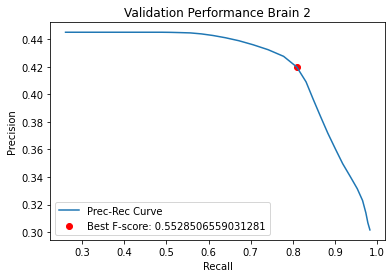

In [42]:
true_pos_total = 0
false_pos_total = 0
true_labels_total = 0
thresholds = np.arange(0.1,1.0,0.02)
precisions = []
recalls = []
best_fscore = 0

for threshold in thresholds:
    for i in range(10):
        fname = "/Users/thomasathey/Documents/mimlab/mouselight/ailey/benchmark_formal/brain2/val_" + str(i) + ".h5"
        f = h5py.File(fname, 'r')
        im = f.get('image_2channel')
        im_bg = im[0,:,:,:]
        im_fg = im[1,:,:,:]

        fname = "/Users/thomasathey/Documents/mimlab/mouselight/ailey/benchmark_formal/brain2/val_" + str(i) + "-image_2channel_Labels.h5"
        f = h5py.File(fname, 'r')
        gt = f.get('exported_data')
        gt = gt[0,:,:,:]
        pos_labels = gt == 2
        num_pos_labels = np.sum(pos_labels)

        fname = "/Users/thomasathey/Documents/mimlab/mouselight/ailey/benchmark_formal/brain2/val_" + str(i) + "_Probabilities.h5"
        f = h5py.File(fname, 'r')
        seg = f.get('exported_data')
        seg = seg[1,:,:,:]
        mask = seg > threshold

        true_pos = np.sum(np.logical_and(mask, pos_labels))
        true_pos_total += true_pos
        false_pos = np.sum(np.logical_and(mask, gt == 1))
        false_pos_total += false_pos
        true_labels = np.sum(pos_labels)
        true_labels_total += true_labels
        
        if num_pos_labels > 0:
            precision = true_pos/(true_pos + false_pos)
            recall = true_pos/true_labels
            #print(f"Example {i}: precision: {precision}, recall: {recall}")
        else:
            #print(f"Example {i}: 0 positive labels, false positive rate is: {false_pos/np.sum(gt == 1)}")
            pass

        '''
        viewer = napari.Viewer(ndisplay=3)
        viewer.add_image(im_bg)
        viewer.add_image(im_fg)
        viewer.add_labels(gt)
        viewer.add_labels(mask)
        napari.run()
        '''
        
    precision_total = true_pos_total/(true_pos_total + false_pos_total)
    recall_total = true_pos_total/true_labels_total
    fscore = 2/(1/precision_total+1/recall_total)
    print(f"Threshold: {threshold} ----- Total precision: {precision_total} total recall: {recall_total} with {true_labels_total} total positive voxels. F-score: {fscore}")
    if fscore > best_fscore:
        best_fscore = fscore
        best_prec = precision_total
        best_recall = recall_total
    precisions.append(precision_total) 
    recalls.append(recall_total)


plt.plot(recalls, precisions, label='Prec-Rec Curve')
plt.scatter([best_recall], [best_prec], c='red', label=f"Best F-score: {best_fscore}")
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.title('Validation Performance Brain 2')
plt.legend()

## Check whole brain results

In [24]:
#download from cloud
centers = [[2304, 3840, 2100], [2560, 3840, 1800]]

for i,center in enumerate(centers):
    image_fg = vol_fg[center[0]:center[0]+256,center[1]:center[1]+256, center[2]:center[2]+300]
    image_fg = image_fg[:,:,:,0]

    image_bg = vol_bg[center[0]:center[0]+256,center[1]:center[1]+256, center[2]:center[2]+300]
    image_bg = image_bg[:,:,:,0]

    mask_s3 = vol_mask[center[0]:center[0]+256,center[1]:center[1]+256, center[2]:center[2]+300]
    mask_s3 = mask_s3[:,:,:,0]

    image_2channel = np.stack([image_bg, image_fg], axis=0)
    fname = "/Users/thomasathey/Documents/mimlab/mouselight/ailey/benchmark_formal/test_" + str(i) + ".h5"
    with h5py.File(fname, "w") as f:
        dset = f.create_dataset("image_2channel", data=image_2channel)

    

Downloading: 2398it [00:32, 73.56it/s]  
Downloading: 2390it [00:29, 80.25it/s]  
Downloading: 1188it [00:07, 155.96it/s]
Downloading: 2392it [00:11, 203.25it/s] 
Downloading: 2392it [00:11, 199.86it/s] 
Downloading: 1186it [00:07, 154.02it/s]


In [20]:
#read ilastik output
fname = "/Users/thomasathey/Documents/mimlab/mouselight/ailey/benchmark_formal/test_1_Probabilities.h5"
f = h5py.File(fname, 'r')
im = f.get('exported_data')
pred = im[1,:,:,:]
mask = pred > 0.32

In [22]:
#read cis file
fname = "/Users/thomasathey/Documents/mimlab/mouselight/ailey/image_1800.h5"
f = h5py.File(fname, 'r')
im = f.get('image_2channel')
image_fg_cis = im[1,:,:,:,0]
image_bg_cis = im[0,:,:,:,0]

#read cis file
fname = "/Users/thomasathey/Documents/mimlab/mouselight/ailey/image_1800_Probabilities.h5"
f = h5py.File(fname, 'r')
ks = list(f.keys())
pred = f[ks[0]]
pred_cis = pred[1,:,:,:]
pred_cis = np.squeeze(pred_cis)
mask_cis = pred_cis > 0.32

In [25]:
viewer = napari.Viewer(ndisplay=3)
viewer.add_image(image_fg)
viewer.add_image(image_bg)
viewer.add_labels(mask_s3)
viewer.add_labels(mask)
viewer.add_image(image_fg_cis)
viewer.add_image(image_bg_cis)
viewer.add_labels(mask_cis)
napari.run()

In [11]:
fname = "/Users/thomasathey/Documents/mimlab/mouselight/ailey/image_0.h5"

subprocess.run(["/Applications/ilastik-1.3.3post3-OSX.app/Contents/ilastik-release/run_ilastik.sh",  "--headless", "--project=/Users/thomasathey/Documents/mimlab/mouselight/ailey/benchmark_formal/matt_benchmark_formal.ilp", fname], stdout=subprocess.PIPE, stderr=subprocess.PIPE)

CompletedProcess(args=['/Applications/ilastik-1.3.3post3-OSX.app/Contents/ilastik-release/run_ilastik.sh', '--headless', '--readonly', '--project=/Users/thomasathey/Documents/mimlab/mouselight/ailey/benchmark_formal/matt_benchmark_formal.ilp', '/Users/thomasathey/Documents/mimlab/mouselight/ailey/image_0.h5'], returncode=1, stdout=b'INFO ilastik_main: Starting ilastik from "/Applications/ilastik-1.3.3post3-OSX.app/Contents/ilastik-release".\nStarting ilastik from "/Applications/ilastik-1.3.3post3-OSX.app/Contents/ilastik-release".\nINFO ilastik.shell.projectManager: Opening Project: /Users/thomasathey/Documents/mimlab/mouselight/ailey/benchmark_formal/matt_benchmark_formal.ilp\n', stderr=b'Warning: Ignoring your non-empty PYTHONPATH/PYTHONHOME\n/Applications/ilastik-1.3.3post3-OSX.app/Contents/ilastik-release/ilastik-meta/lazyflow/lazyflow/classifiers/__init__.py:20: UserWarning: init: Could not import tiktorch classifier\n  warnings.warn("init: Could not import tiktorch classifier")\n

# Old

# Evaluate results


### Read ilastik

In [8]:
base_path = "/Users/thomasathey/Documents/mimlab/mouselight/ailey/benchmark/"

part = "4"

im_path  = base_path + part + ".tif"
image = io.imread(im_path)

pred_path = base_path + part + "_Probabilities_3d_2channel.h5"
f = h5py.File(pred_path, 'r')
pred = f.get('exported_data')
print(pred.shape)
pred = pred[1,:,:,:]
mask = pred > 0.5
mask = removeSmallCCs(mask, 100)
print(f"sum: {np.sum(mask)}")

(2, 200, 200, 200)
sum: 744


### Read swcs

In [3]:
from brainlit.utils.Neuron_trace import NeuronTrace
from pathlib import Path
from scipy.ndimage import distance_transform_edt

In [4]:
swc_path = Path("/Users/thomasathey/Documents/mimlab/mouselight/ailey/" + part + "_traces/")

swc_files = list(swc_path.glob("**/*.swc"))

paths_total = []
for swc_num, swc in enumerate(swc_files):

    swc_trace = NeuronTrace(path=str(swc))
    paths = swc_trace.get_paths()
    offset_diff, _, _, _ = swc_trace.get_df_arguments()

    for path_num, p in enumerate(paths):
        paths_total.append(p)

In [5]:
swc_mask = 0*mask
for path in paths_total:
    path = path.astype(int)
    swc_mask[path[:,0], path[:,1], path[:,2]] = 1
    
edt = distance_transform_edt(swc_mask==0)
swc_mask[edt < 2] = 1

In [10]:
viewer = napari.Viewer(ndisplay=3)
viewer.add_image(np.swapaxes(image,0,2))
viewer.add_labels(np.swapaxes(mask,0,2))
#viewer.add_labels(swc_mask)
#viewer.add_shapes(data=paths_total, shape_type='path', edge_width=1.0, edge_color='blue', opacity=0.8)

<Labels layer 'Labels' at 0x1641747c0>

In [ ]:
tpr = np.sum(np.logical_and(swc_mask, np.swapaxes(mask,0,2)))/np.sum(swc_mask)
fpr = np.sum(np.logical_and(swc_mask==0, np.swapaxes(mask==1,0,2)))/np.sum(swc_mask==0)
print(f"TPR: {tpr}, FPR: {fpr}")

# Check blocks
## Download data

In [18]:
block_num = 500
with open("/Users/thomasathey/Documents/mimlab/mouselight/ailey/wholebrain_results/coords_1_unique.txt") as fp:
    counter = 0
    for line in fp:
        if counter == block_num:
            words = line.split()
            corner = [int(word) for word in words]
        counter += 1

dims = [200,200,600]
image_fg = vol_fg[corner[0]:corner[0]+dims[0], corner[1]:corner[1]+dims[1], corner[2]:corner[2]+dims[2]]
image_bg = vol_bg[corner[0]:corner[0]+dims[0], corner[1]:corner[1]+dims[1], corner[2]:corner[2]+dims[2]]


Downloading: 4796it [01:07, 71.27it/s]  
Downloading: 4796it [01:05, 73.19it/s]  


In [19]:
viewer = napari.Viewer(ndisplay=3)
viewer.add_image(image_fg[:,:,:,0])
viewer.add_image(image_bg[:,:,:,0])
napari.run()

In [28]:
from random import sample
import numpy as np 
from tqdm import tqdm 

s = sample(list(np.arange(0, 659)), 10)
dims = [200,200,600]

for block_num in s:
    with open("/Users/thomasathey/Documents/mimlab/mouselight/ailey/wholebrain_results/coords_1_unique.txt") as fp:
        counter = 0
        for line in fp:
            if counter == block_num:
                words = line.split()
                corner = [int(word) for word in words]
            counter += 1
    upper_bd = [np.amin([corner[i]+dims[i], vol_fg.shape[i]]) for i in range(3)]
    image_fg = vol_fg[corner[0]:upper_bd[0], corner[1]:upper_bd[1], corner[2]:upper_bd[2]]
    image_bg = vol_bg[corner[0]:corner[0]+dims[0], corner[1]:corner[1]+dims[1], corner[2]:corner[2]+dims[2]]
    image_2channel = np.stack([image_bg, image_fg], axis=0)
    fname = "/Users/thomasathey/Documents/mimlab/mouselight/ailey/wholebrain_results/images/on_" + str(block_num) + ".h5"
    with h5py.File(fname, "w") as f:
        dset = f.create_dataset("image_2channel", data=image_2channel)


Downloading: 7194it [01:45, 67.98it/s]  
Downloading: 7198it [01:39, 72.00it/s]  
Downloading: 7198it [01:40, 71.44it/s]  
Downloading: 7192it [01:33, 76.79it/s]  
Downloading: 7192it [01:39, 72.04it/s]  
Downloading: 7198it [01:42, 70.31it/s]  
Downloading: 4798it [00:55, 87.11it/s]  
Downloading: 4786it [00:54, 87.36it/s]  
Downloading: 10790it [02:23, 75.06it/s]  
Downloading: 10790it [02:28, 72.42it/s]  
Downloading: 10796it [02:31, 71.36it/s]  
Downloading: 10794it [02:23, 75.30it/s]  
Downloading: 7190it [00:33, 214.82it/s] 
Downloading: 7188it [00:36, 198.07it/s] 
Downloading: 10796it [02:27, 73.23it/s]  
Downloading: 10798it [02:34, 70.03it/s]  
Downloading: 10796it [02:33, 70.40it/s]  
Downloading: 10798it [02:31, 71.18it/s]  
Downloading: 4796it [01:07, 71.18it/s]  
Downloading: 4792it [01:07, 70.76it/s]  


In [18]:
#0,1,2,3,5 artifact (2)
#4,7,8,9 - positive, 6?
blocks = [62, 115, 155, 277, 304, 358, 424, 508, 622, 636]
block_num = blocks[5]
print("Reading output")
fname = "/Users/thomasathey/Documents/mimlab/mouselight/ailey/wholebrain_results/images/on_" + str(block_num) + "_Probabilities_3d_2channel.h5"
f = h5py.File(fname, "r")
ks = list(f.keys())
pred = f[ks[0]]
pred = pred[1,:,:,:,0]
mask = pred > 0.5
labels = measure.label(mask)
props = measure.regionprops(labels)
for prop in props:
    if prop.area < 100:
        labels[labels == prop.label] = 0


print("Reading input")
fname = "/Users/thomasathey/Documents/mimlab/mouselight/ailey/wholebrain_results/images/on_" + str(block_num) + ".h5"
f = h5py.File(fname, "r")
ks = list(f.keys())
im = f[ks[0]]
im_bg = im[0,:,:,:,0]
im_fg = im[1,:,:,:,0]

viewer = napari.Viewer(ndisplay=3)
viewer.add_image(im_bg)
viewer.add_image(im_fg)
viewer.add_labels(labels)
napari.run()

Reading output
Reading input


# Make annotation layer

Making new annotation layer
-output data and x,y,z bounds

In [9]:
vol_bg.volume_size

Vec(7403,10240,4800, dtype=int64)

cannot write to https link, can write to s3 link

In [38]:
dir = "s3://smartspim-precomputed-volumes/2021_04_08/gad2cre_tph2flp_con_fon_8291/axon_mask"

info = CloudVolume.create_new_info(
    num_channels    = 1,
    layer_type      = 'segmentation',
    data_type       = 'uint64', # Channel images might be 'uint8'
    encoding        = 'raw', # raw, jpeg, compressed_segmentation, fpzip, kempressed
    resolution      = vol_bg.resolution, # Voxel scaling, units are in nanometers
    voxel_offset    = vol_bg.voxel_offset, # x,y,z offset in voxels from the origin
    # mesh            = 'mesh',
    # Pick a convenient size for your underlying chunk representation
    # Powers of two are recommended, doesn't need to cover image exactly
    chunk_size      = [ 128, 128, 2 ], # units are voxels
    volume_size     = vol_bg.volume_size, # e.g. a cubic millimeter dataset
)
vol_mask = CloudVolume(dir, info=info)
vol_mask.commit_info()

In [14]:
vol_mask.volume_size

Vec(7403,10240,4800, dtype=int64)

In [26]:

image_fg = vol_fg[2432:2560, 3584:3712, 2400:2440]
image_bg = vol_bg[2432:2560, 3584:3712, 2400:2440]
image_2channel = np.stack([image_bg, image_fg], axis=0)
fname = "/Users/thomasathey/Documents/mimlab/mouselight/ailey/example_annotation/example.h5"
with h5py.File(fname, "w") as f:
    dset = f.create_dataset("image_2channel", data=image_2channel)

Downloading: 50it [00:00, 55.15it/s]
Downloading: 76it [00:00, 79.60it/s]


In [36]:
example = "off_2"

fname = "/Users/thomasathey/Documents/mimlab/mouselight/ailey/example_annotation/example.h5"
f = h5py.File(fname, 'r')
im = f.get('image_2channel')
im_fg = im[1,:,:,:,0]

fname = "/Users/thomasathey/Documents/mimlab/mouselight/ailey/example_annotation/example_Probabilities_3d_2channel.h5"
f = h5py.File(fname, 'r')
pred = f.get('exported_data')
pred = pred[1,:,:,:,0]
mask = pred > 0.5
try:
    mask = removeSmallCCs(mask, 100)
except ValueError:
    mask = 0*im_fg

print(im_fg.shape == mask.shape)

viewer = napari.Viewer(ndisplay=3)
viewer.add_image(im_fg)
viewer.add_labels(mask)
napari.run()

True


In [46]:
vol_mask[2432:2560, 3584:3712, 2400:2440, 0] = mask.astype('uint64')

Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Uploading:   0%|          | 0/1 [00:00<?, ?it/s]


Uploading:   0%|          | 0/1 [00:00<?, ?it/s]



Uploading:   0%|          | 0/1 [00:00<?, ?it/s]




Uploading:   0%|          | 0/1 [00:00<?, ?it/s]





Uploading:   0%|          | 0/1 [00:00<?, ?it/s]






Uploading:   0%|          | 0/1 [00:00<?, ?it/s]







Uploading:   0%|          | 0/1 [00:00<?, ?it/s]








Uploading:   0%|          | 0/1 [00:00<?, ?it/s]









Uploading:   0%|          | 0/1 [00:00<?, ?it/s]










Uploading:   0%|          | 0/1 [00:00<?, ?it/s]











Uploading:   0%|          | 0/1 [00:00<?, ?it/s]












Uploading:   0%|          | 0/1 [00:00<?, ?it/s]













Uploading:   0%|          | 0/1 [00:00<?, ?it/s]














Uploading:   0%|          | 0/1 [00:00<?, ?it/s]















Uploading:   0%|          | 0/1 [00:00<?, ?it/s]
















Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

















Uploading:   0

In [32]:
mask2 = vol_mask[2432:2560, 3584:3712, 2400:2440, 0]
mask2.shape

Downloading:   0%|          | 0/20 [00:00<?, ?it/s]


(128, 128, 40, 1)

In [33]:
mask.shape

(128, 128, 40, 1)

https://viz.neurodata.io/?json_url=https://json.neurodata.io/v1?NGStateID=E-917tNc_GylnQ

## Brainlit example

In [ ]:
dir = "s3://open-neurodata/brainlit/brain2/axons"

info = CloudVolume.create_new_info(
    num_channels    = 1,
    layer_type      = 'segmentation',
    data_type       = 'uint64', # Channel images might be 'uint8'
    encoding        = 'raw', # raw, jpeg, compressed_segmentation, fpzip, kempressed
    resolution      = vol_brainlit.resolution, # Voxel scaling, units are in nanometers
    voxel_offset    = vol_brainlit.voxel_offset, # x,y,z offset in voxels from the origin
    # mesh            = 'mesh',
    # Pick a convenient size for your underlying chunk representation
    # Powers of two are recommended, doesn't need to cover image exactly
    chunk_size      = [ 68, 52, 80 ], # units are voxels
    volume_size     = vol_brainlit.volume_size, # e.g. a cubic millimeter dataset
)
vol = CloudVolume(dir, info=info)
vol.commit_info()

In [10]:
import numpy as np 

In [13]:
a = np.zeros((68,52,80), dtype='uint64')
a[30:35,:,:] = 1
vol[:68,:52,:80] = a

Uploading:   0%|          | 0/1 [00:00<?, ?it/s]


# Second sample

In [9]:
dir = "precomputed://https://dlab-colm.neurodata.io/2021_06_02_Sert_Cre/Ch_647"

vol_fg = CloudVolume(dir)

## Download and save samples

In [16]:
pos_centers = [[3071, 765, 2342], [5065, 3455, 2342], [3262, 7854, 2342]] #tectum, cortex, olfactory bulb
neg_centers = [[3557, 4797, 2342], [1564, 1997, 2342], [1606, 5204, 2342]] #?, edge of brain/tectum, white matter
radius = 100

for i, center in enumerate(pos_centers):
    image_fg = vol_fg[center[0]-radius:center[0]+radius, center[1]-radius:center[1]+radius, center[2]-radius:center[2]+radius]
    image_bg = 0*image_fg
    image_2channel = np.stack([image_bg, image_fg], axis=0)
    fname = "/Users/thomasathey/Documents/mimlab/mouselight/ailey/brain2_data/images/on_" + str(i) + ".h5"
    with h5py.File(fname, "w") as f:
        dset = f.create_dataset("image_2channel", data=image_2channel)


for i, center in enumerate(neg_centers):
    image_fg = vol_fg[center[0]-radius:center[0]+radius, center[1]-radius:center[1]+radius, center[2]-radius:center[2]+radius]
    image_bg = 0*image_fg
    image_2channel = np.stack([image_bg, image_fg], axis=0)
    fname = "/Users/thomasathey/Documents/mimlab/mouselight/ailey/brain2_data/images/off_" + str(i) + ".h5"
    with h5py.File(fname, "w") as f:
        dset = f.create_dataset("image_2channel", data=image_2channel)

Downloading: 2388it [00:36, 65.59it/s] 
Downloading: 2390it [00:27, 86.18it/s]  
Downloading: 3594it [00:50, 71.85it/s]  


## Read ilastik results

In [8]:
example = "off_2"

fname = "/Users/thomasathey/Documents/mimlab/mouselight/ailey/brain2_data/images/" + example + ".h5"
f = h5py.File(fname, 'r')
im = f.get('image_2channel')
im_fg = im[1,:,:,:,0]

fname = "/Users/thomasathey/Documents/mimlab/mouselight/ailey/brain2_data/images/" + example + "_Probabilities_3d_2channel.h5"
f = h5py.File(fname, 'r')
pred = f.get('exported_data')
pred = pred[1,:,:,:,0]
mask = pred > 0.5

try:
    mask = removeSmallCCs(mask, 100)
except ValueError:
    mask = 0*im_fg

print(im_fg.shape == mask.shape)

viewer = napari.Viewer(ndisplay=3)
viewer.add_image(im_fg)
viewer.add_labels(mask)
napari.run()

True


brain 1

In [43]:
from brainlit.utils import NeuroglancerSession

In [16]:
vol_im1 = CloudVolume('https://open-neurodata.s3.amazonaws.com/brainlit/brain1', parallel=1, mip=0, fill_missing=True)
vol_skel1 = CloudVolume('precomputed://https://open-neurodata.s3.amazonaws.com/brainlit/brain1_segments')
skel2 = vol_skel1.skeleton.get(11)
skel2.vertices
#session = NeuroglancerSession("s3://open-neurodata/brainlit/brain1", 0)

Downloading: 100%|██████████| 1/1 [00:00<00:00,  6.04it/s]


array([[3011911.5, 3276767.2, 5687712.5],
       [3004739.8, 3291076. , 5646200.5],
       [3000450.8, 3299581.8, 5623540.5],
       ...,
       [2085661.6, 1645958.8, 5569204.5],
       [2075075.6, 1640503.6, 5587982. ],
       [2059411.6, 1637445.1, 5593810. ]], dtype=float32)

In [17]:
coord = skel2.vertices[0,:]
coord = np.divide(coord, vol_im1.resolution)

In [18]:
coord

Vec(10107.085570469799,10778.839638157895,5756.794028340081, dtype=float64)

In [28]:
coord = [19796.43356643, 14046.11235955,  5254.32142857]
coord = [int(c) for c in coord]
image = vol_im1[coord[0]-50:coord[0]+50, coord[1]-50:coord[1]+50, coord[2]-50:coord[2]+50]
image = np.squeeze(image)
image.shape

Downloading:   0%|          | 0/8 [00:01<?, ?it/s]


(100, 100, 100)

In [29]:
viewer = napari.Viewer(ndisplay=3)
viewer.add_image(image)
napari.run()

In [26]:
m = np.zeros((3))
m = np.subtract([12909, 12494, 4479],[10107, 10778, 5756])/np.subtract([1317, 1300, 885],[1031, 1122, 1137])
y = np.add(np.multiply(np.subtract(x, [1317, 1300, 885]), m), [12909, 12494, 4479])

In [ ]:
y

In [30]:
np.multiply([1317, 1300, 885], )

array([9.7972028 , 9.64044944, 5.06746032])